In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v0')

In [21]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        mb_noise=False,
        coef_u = 3.,
        coef_tau = .3,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [22]:
#learning   
l = .1
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [30]:
a.load_weights('../saved_agent/linear_init.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, episode_time=5.)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 111s 11ms/step - reward: -0.1489
396 episodes - episode_reward: -3.757 [-10.507, -0.155] - loss: 0.029 - mean_squared_error: 0.058 - mean_q: 0.876

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 117s 12ms/step - reward: -0.0919
301 episodes - episode_reward: -3.055 [-5.042, -0.578] - loss: 0.028 - mean_squared_error: 0.057 - mean_q: 1.329

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 142s 14ms/step - reward: -0.0924
301 episodes - episode_reward: -3.069 [-5.929, -0.718] - loss: 0.033 - mean_squared_error: 0.067 - mean_q: 1.460

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 164s 16ms/step - reward: -0.0669
289 episodes - episode_reward: -2.317 [-4.167, -0.065] - loss: 0.031 - mean_squared_error: 0.061 - mean_q: 1.353

Interval 5 (40000 steps performed)
10000/10000 [========

10000/10000 [==============================] - 158s 16ms/step - reward: -0.0547
243 episodes - episode_reward: -2.244 [-4.967, -0.375] - loss: 0.002 - mean_squared_error: 0.005 - mean_q: 0.388

Interval 37 (360000 steps performed)
10000/10000 [==============================] - 203s 20ms/step - reward: -0.0567
241 episodes - episode_reward: -2.353 [-4.723, -0.534] - loss: 0.002 - mean_squared_error: 0.004 - mean_q: 0.359

Interval 38 (370000 steps performed)
10000/10000 [==============================] - 372s 37ms/step - reward: -0.0568
239 episodes - episode_reward: -2.382 [-4.779, -0.424] - loss: 0.002 - mean_squared_error: 0.004 - mean_q: 0.344

Interval 39 (380000 steps performed)
 6948/10000 [===================>..........] - ETA: 1:40 - reward: -0.0600done, took 6446.015 seconds


(41, 2)
(51, 2)
(55, 2)
(46, 2)
(43, 2)
(47, 2)
(31, 2)
(35, 2)
(29, 2)
(27, 2)


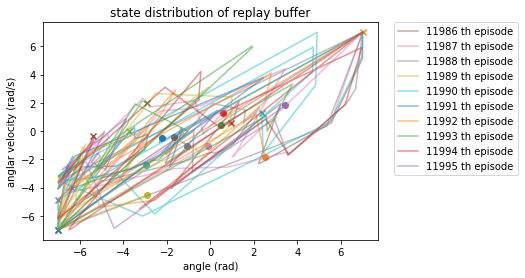

In [31]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, em in enumerate(a.state_memory):
    if i<len(a.state_memory)-10:
        continue
    print(em.shape)
    plt.scatter(em[0,0], em[0,1], marker='o', color=cycle[i % 10])
    plt.scatter(em[-1,0], em[-1,1], marker='x', color=cycle[i % 10])
    plt.plot(em[:,0], em[:,1], color=cycle[i % 10], label=f'{i+1} th episode', alpha=0.5)
plt.xlabel('angle (rad)')
plt.ylabel('anglar velocity (rad/s)')
plt.title('state distribution of replay buffer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.xlim(-10, 10)
plt.show()

In [34]:
a.training = False

env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = a.forward(x)
    tau = np.clip(tau, .01, 1.)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(a.forward(env.state)[0])
states = np.array(states)
detail_states = np.array(detail_states)

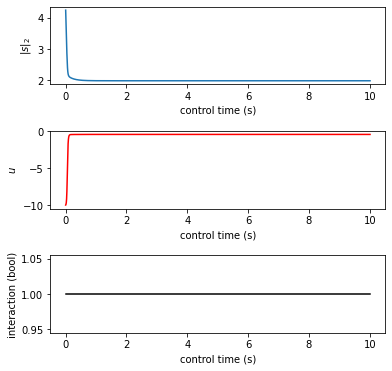

In [35]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [36]:
a.save_weights('../saved_agent/large_noise0.h5')